## 数据加载

这里比较简单直接运行加载即可.

In [1]:
import matplotlib.pyplot as plt

In [81]:
import os

import numpy as np
import pandas as pd
import pyDAW

# 分别控制文件数量和电压
raw_filess = [
    [
        f"/home/daq/daq_2730/CoMPASS-v2.4.1/SiPM_VUV4/DAQ/VBias{i}/RAW/DataR_CH0@VX2730_53013_VBias{i}_{j}.CSV"
        for j in range(1, 3)
    ]
    for i in range(55, 64)
]

# 读取 CSV 文件，其中分隔符为 ';'
waveforms = []
for raw_files in raw_filess:
    df_combine = []
    for raw_file in raw_files:
        df = pd.read_csv(raw_file, delimiter=";", skiprows=2)
        if df.isna().any().any():
            print(f"文件 {raw_file} 存在 NaN 值")
            # 根据具体需求，可以选择填充或删除缺失值
            # 例如：填充缺失值为 0
            # df = df.fillna(0)
            # 或者删除含有缺失值的行
            df = df.dropna()
        df_combine.append(df)

    array = [df.to_numpy() for df in df_combine]
    waveform = np.concatenate(array, axis=0)
    waveforms.append(waveform)

看看时间间隔的信息好像也没有很多的信息.

(array([ 972.,  993.,  981.,  992., 1040., 1030.,  984., 1007., 1005.,
         996.]),
 array([2.84054138e+11, 2.85442849e+11, 2.86831560e+11, 2.88220271e+11,
        2.89608983e+11, 2.90997694e+11, 2.92386405e+11, 2.93775116e+11,
        2.95163827e+11, 2.96552538e+11, 2.97941249e+11]),
 <BarContainer object of 10 artists>)

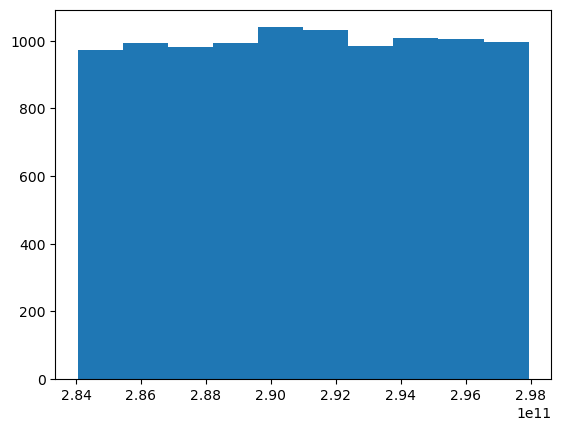

In [3]:
time = [waveforms[0][i][2] for i in range(10000)]
plt.hist(time)

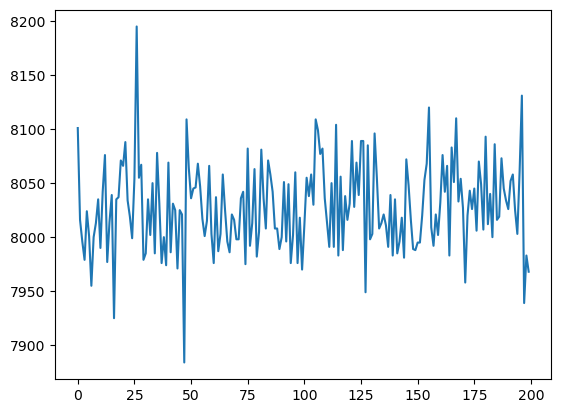

In [4]:
plt.plot(waveforms[0][0][7:])

## 几种尝试的方法

### 尝试通过卷积的方法找到三个上升的点.

In [5]:
def find_consecutive_positive(arr, num=4, thr=3):
    """
    找到数组中连续三个大于零的部分。

    参数：
    arr (np.ndarray): 输入数组。

    返回：
    np.ndarray: 连续三个大于零的部分的起始索引。
    """

    # 创建一个卷积核，用于检测连续三个正数
    kernel = np.full(num, 1)

    # 将数组转换为布尔数组，True 表示大于零，False 表示小于等于零
    positive_arr = arr < thr

    # 使用卷积操作检测连续三个 True
    convolved = np.convolve(positive_arr, kernel, mode="valid")

    # 找到卷积结果等于 3 的位置，这些位置表示连续三个 True
    indices = np.where(convolved == num)[0]

    return indices


# 示例数据
arr = np.array([1, 2, 3, -1, -4, -5, 6, -2, 7, 8, 9])

# 找到连续三个大于零的部分
indices = find_consecutive_positive(arr)

# 打印结果
print(f"连续三个大于零的部分的起始索引：{indices}")

连续三个大于零的部分的起始索引：[]


### 看看上升沿的统计特征

ValueError: x and y must have the same length.

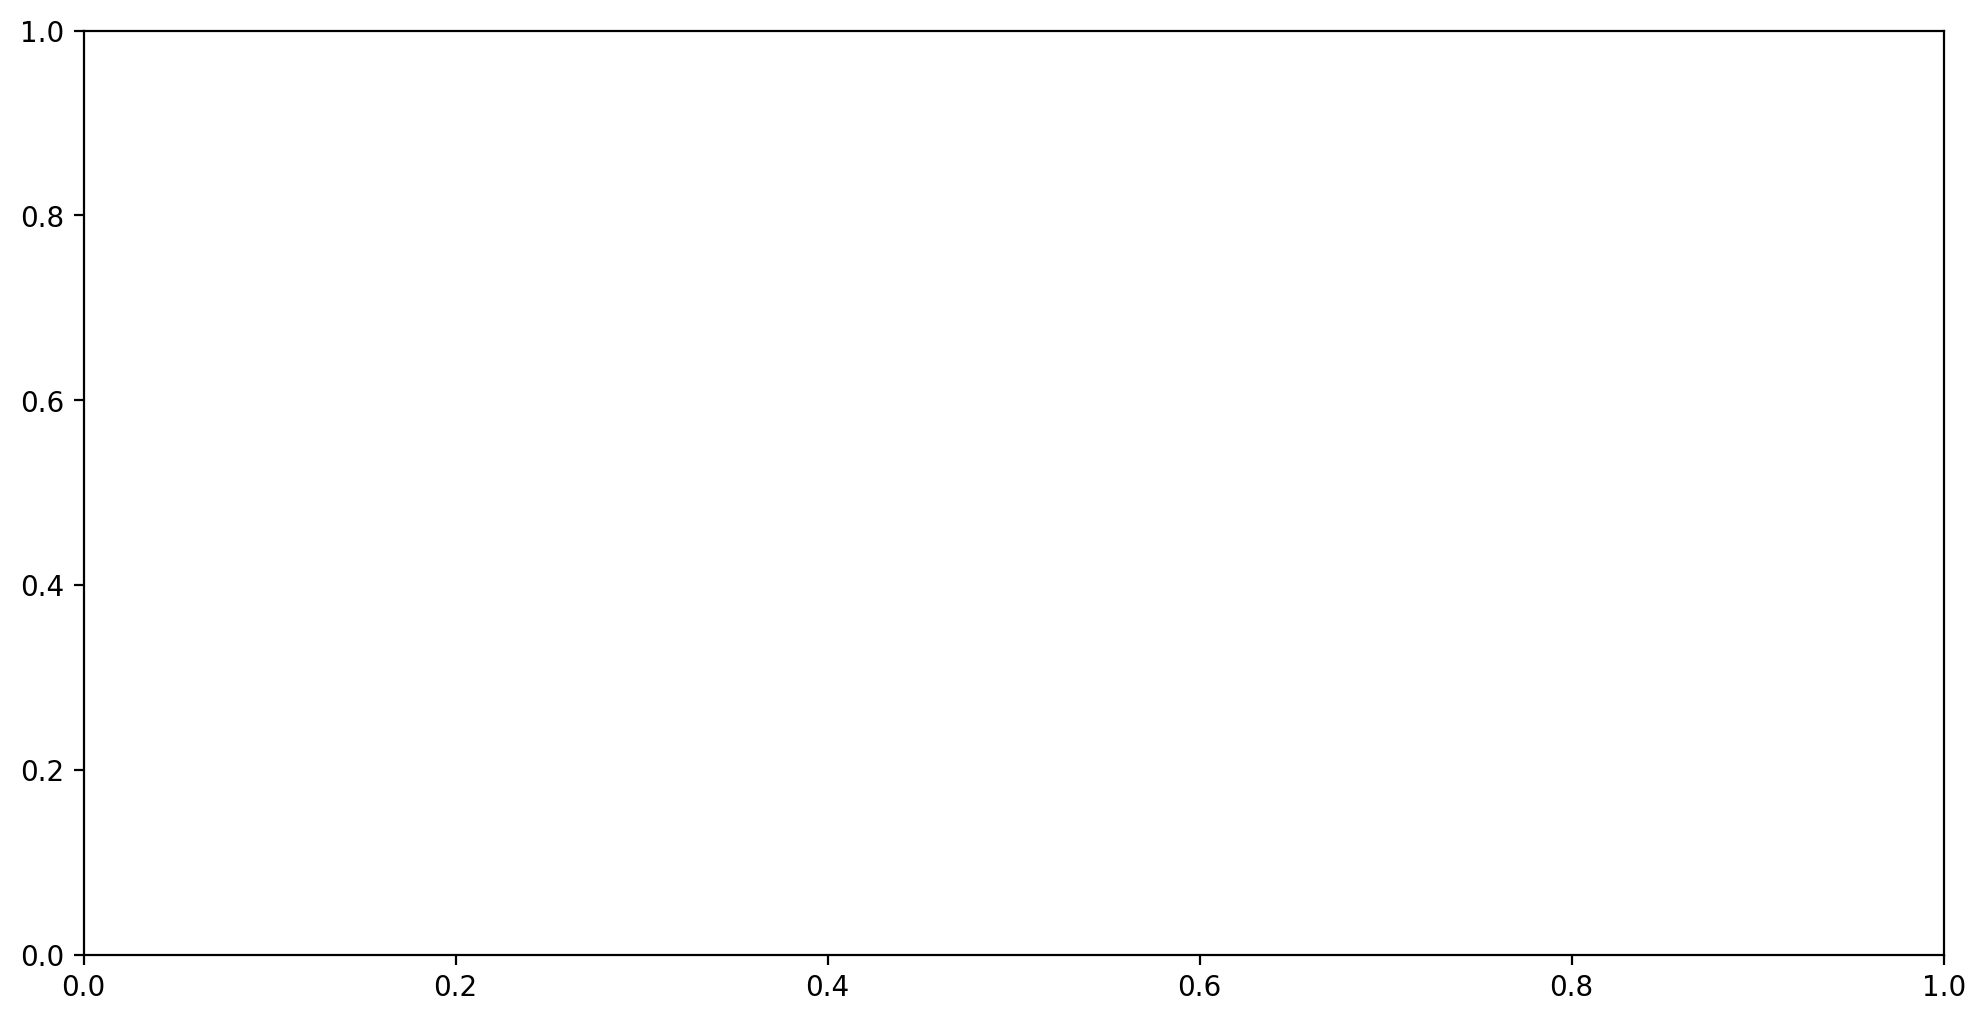

In [6]:
%config InlineBackend.figure_format = 'retina'
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

num = 2000
a = []
for i in range(num):
    a.append(np.linspace(2, 400, 200))
    b = np.array(object=a).flatten()


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist = ax.hist2d(
    b,
    waveform[:num, :].flatten(),
    bins=[np.linspace(0, 400, 200), np.linspace(5000, 8200, 320)],
    norm=LogNorm(),
)

# Save the histogram data (counts, edges)
counts, xedges, yedges, obj = hist
# hist_data.append({"counts": counts, "xedges": xedges, "yedges": yedges})

# ax.set_xlabel("Time [ns]")
# ax.set_ylabel("ADC")
# ax.set_title(f"VBias {54 + j}")

plt.xlim(80, 150)

In [ ]:
np.diff(waveform[:num, 7:], axis=1).shape

(2000, 192)

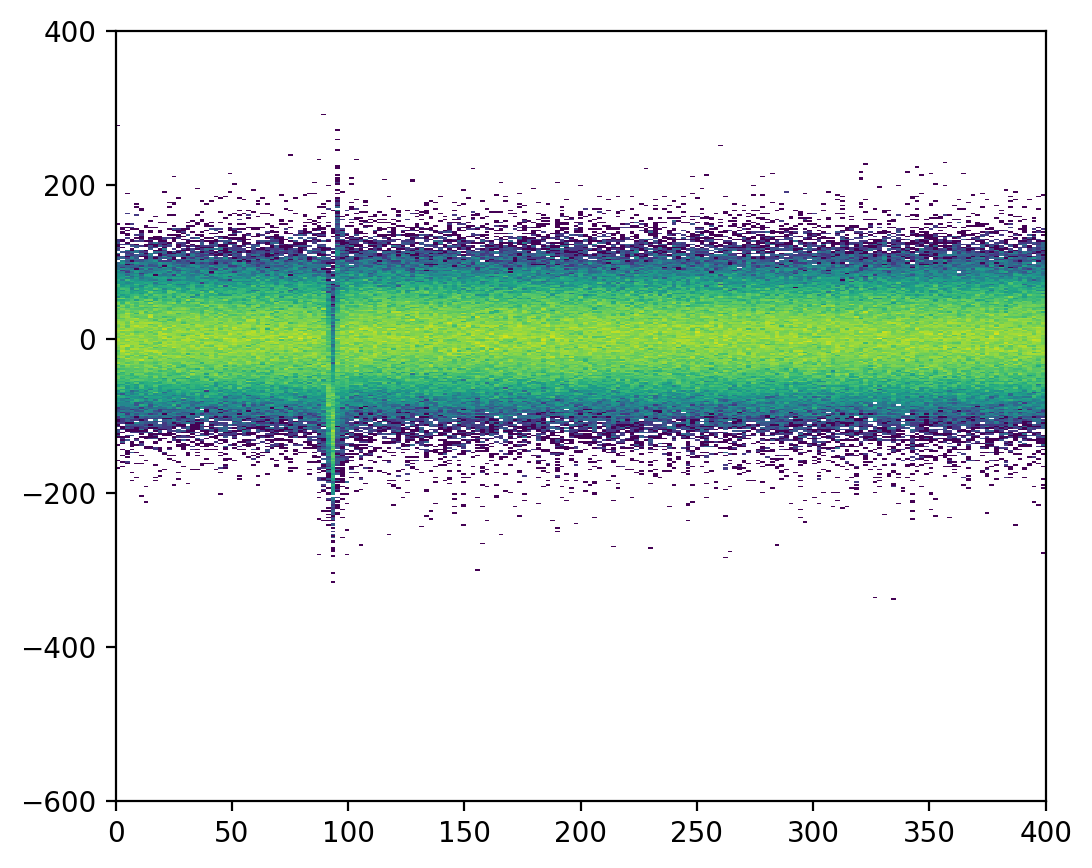

In [ ]:
%config InlineBackend.figure_format = 'retina'
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

num = 2000
a = []
for i in range(num):
    a.append(np.linspace(2, 400, 199))
    b = np.array(object=a).flatten()


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hist = ax.hist2d(
    b,
    np.diff(waveforms[0][:num, 7:], axis=1).flatten(),
    bins=[np.linspace(0, 400, 200), np.linspace(-600, 400, num=500)],
    norm=LogNorm(),
)

# plt.xlim(50,150)

### 在微分谱中找找灵感

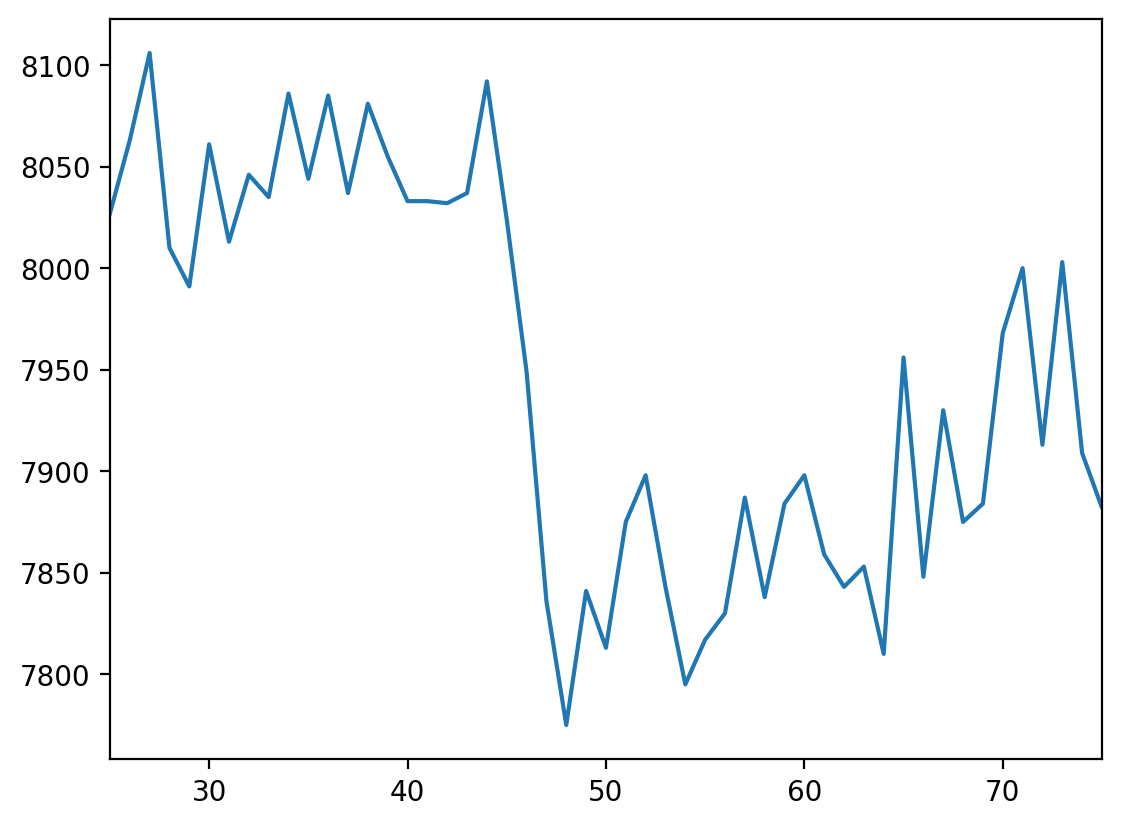

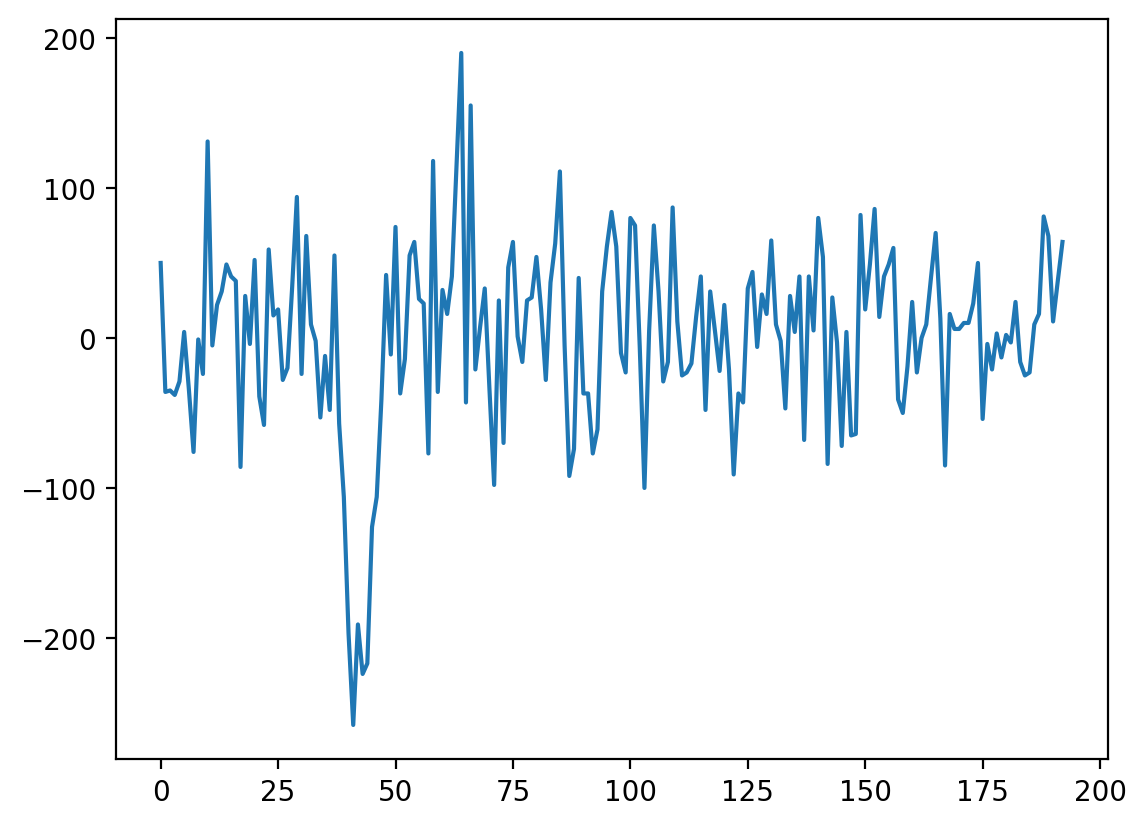

In [ ]:
rand = np.random.randint(0, 10000)

plt.plot(waveforms[0][rand, 7:])
plt.xlim(25, 75)
plt.figure()

data = waveforms[0][rand, 7:]

offset = 7

difference = np.zeros(len(data) - offset)
difference = data[offset:] - data[:-offset]

plt.plot(difference)

### 通过 offset 的方式得到类似于微分谱的图
在不同的 offset 下进行了比较

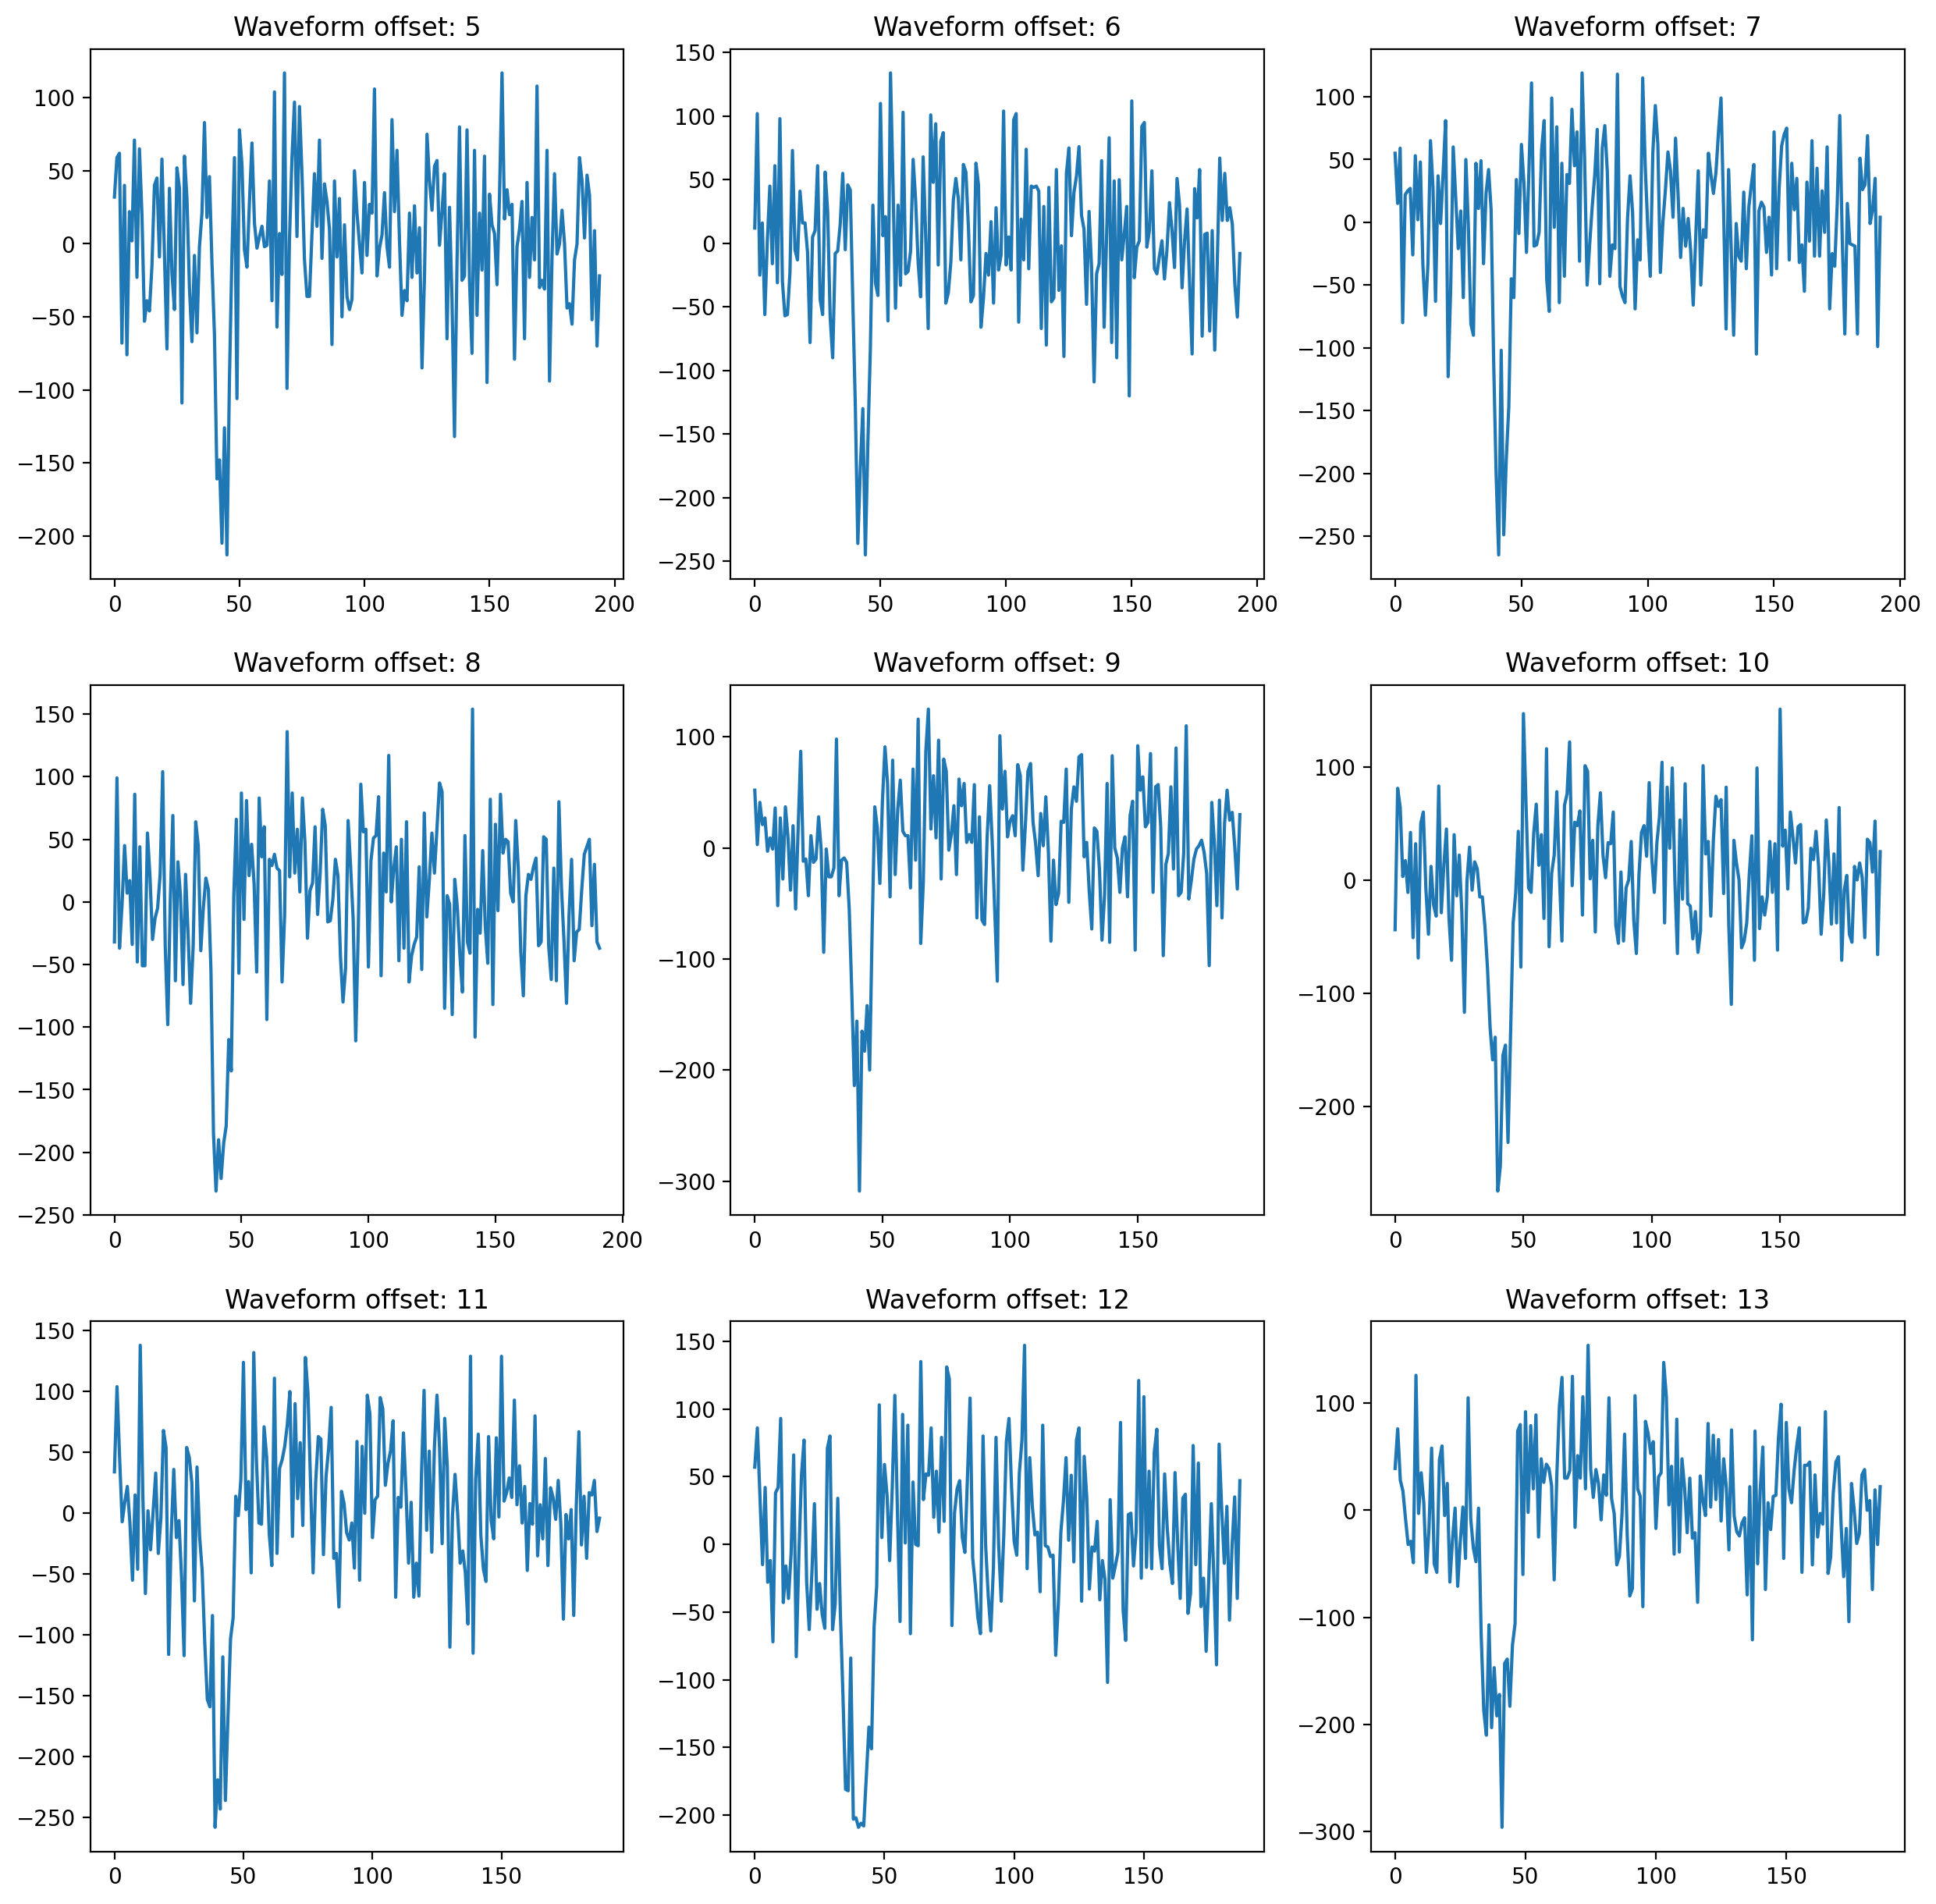

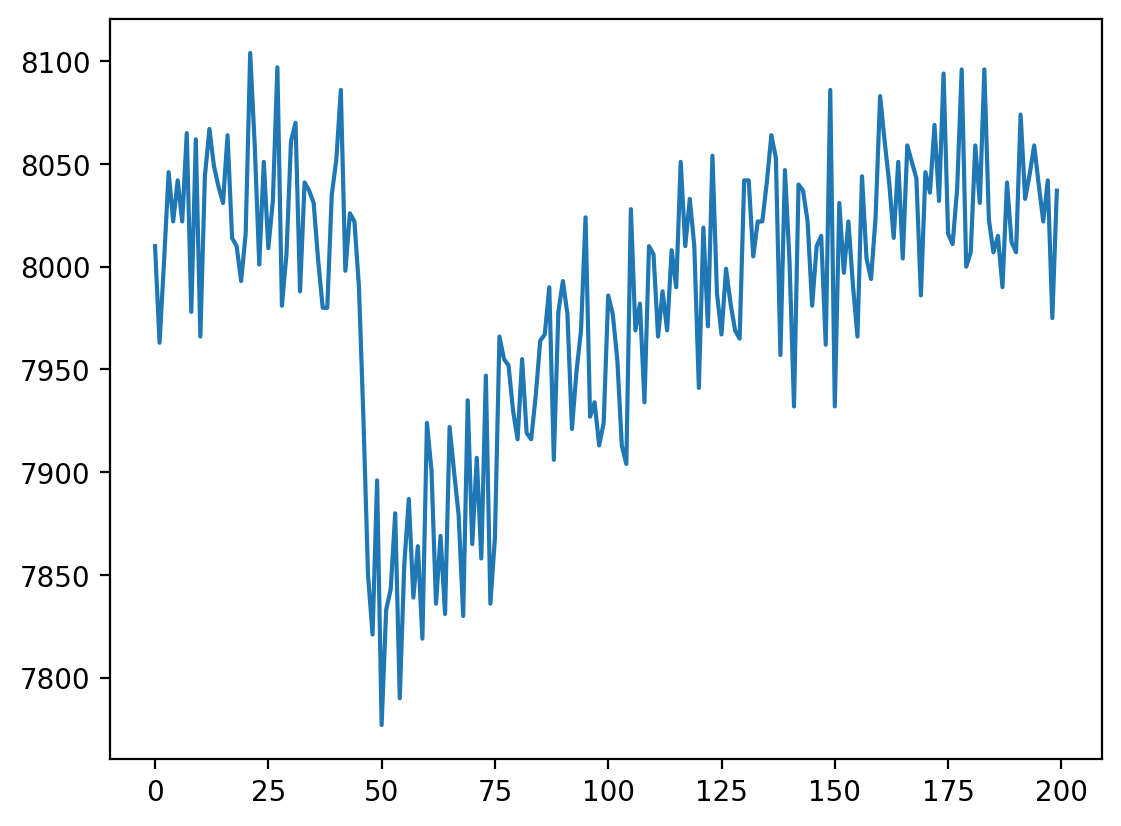

In [ ]:
rand = np.random.randint(0, 10000)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for j in range(9):  # 限制循环范围
    rows = j // 3
    cols = j % 3

    data = waveforms[0][rand, 7:]

    offset = j + 5

    difference = np.zeros(len(data) - offset)
    difference = data[offset:] - data[:-offset]

    axes[rows, cols].plot(difference)
    axes[rows, cols].title.set_text(f"Waveform offset: {offset}")

plt.figure()
plt.plot(waveforms[0][rand, 7:])

## ✔, 滤波+微分谱寻峰

### 滤波后的波形展示

通过 SG 滤波器, 在 10 个点的窗口下进行了二阶滤波, 从而得到了比较平滑的波形, 在降低噪声的同时, 同时保留较多的高频信息.

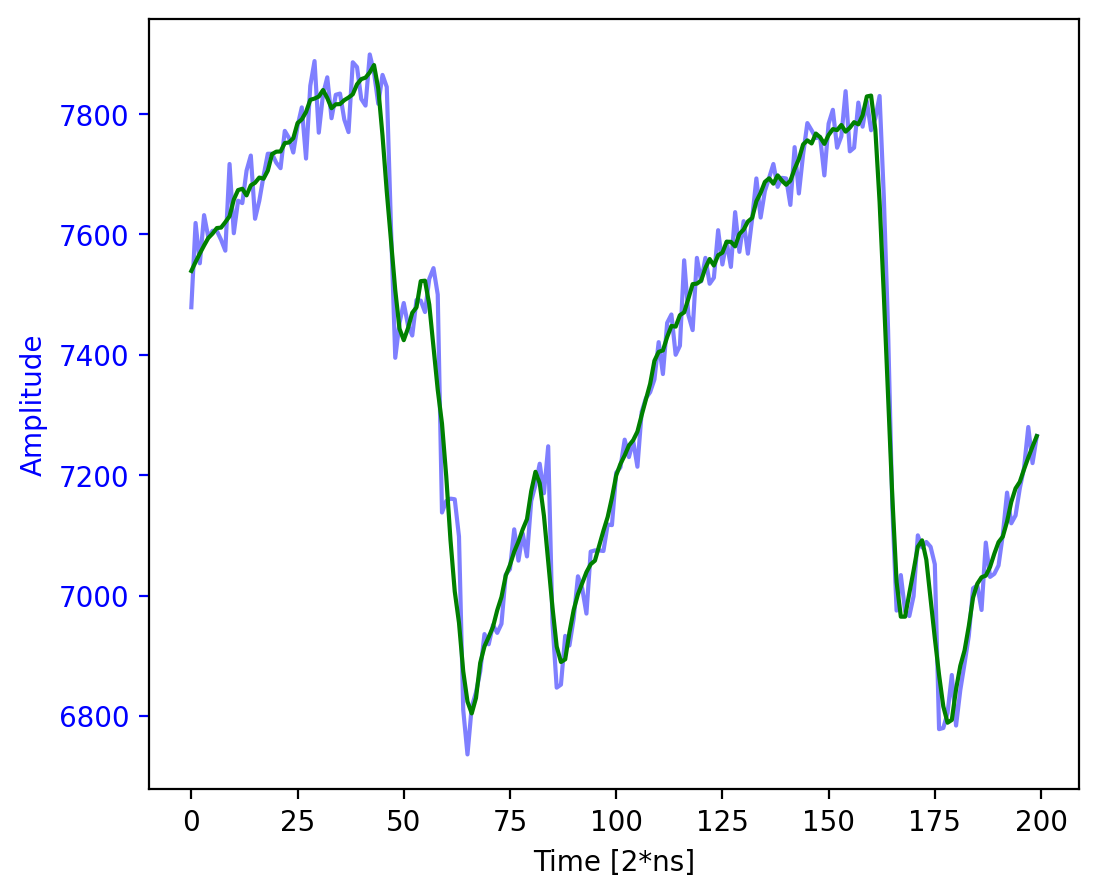

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# 创建一个figure和axis对象
fig, ax1 = plt.subplots(figsize=(6, 5))

# 假设 waveforms 是预先定义的数组或列表（在实际代码中应替换）
waveform = waveforms[4]
rand = np.random.randint(0, 2000)
wave = waveform[rand, 7:]

# 对原始波形应用Savitzky-Golay滤波
window_size = 10
poly_order = 2
smooth_wave = savgol_filter(wave, window_size, poly_order)

# 画出原始波形
ax1.plot(wave.flatten(), label="Raw Signal", color="blue", alpha=0.5)
ax1.plot(smooth_wave.flatten(), label="Smoothed Signal", color="green")
ax1.set_xlabel("Time [2*ns]")
ax1.set_ylabel("Amplitude", color="blue")
ax1.tick_params("y", colors="blue")

# # 创建第二个y轴，共享x轴
# ax2 = ax1.twinx()

# # 计算原始波形的一阶导数
# diff_waveform = np.diff(wave, axis=0).flatten()
# # 计算滤波后波形的一阶导数
# diff_smooth_wave = np.diff(smooth_wave, axis=0).flatten()

# # 应用Savitzky-Golay滤波到一阶导数
# smooth_diff_waveform = savgol_filter(diff_waveform, window_size, poly_order)
# smooth_diff_smooth_wave = savgol_filter(diff_smooth_wave, window_size, poly_order)

# # 画出一阶导数（原始和滤波后的）
# ax2.plot(diff_waveform, color="red", label="Diff of Raw Signal", linestyle='-', alpha=0.6)
# ax2.plot(smooth_diff_waveform, color="purple", label="Smoothed Diff of Raw Signal", linestyle='-.')
# ax2.plot(diff_smooth_wave, color="orange", label="Diff of Smoothed Signal", linestyle='-', alpha=0.6)
# ax2.plot(smooth_diff_smooth_wave, color="black", label="Smoothed Diff of Smoothed Signal", linestyle='--')

# ax2.set_ylabel("First Derivative", color="red")
# ax2.tick_params("y", colors="red")

# # # 添加图例
# # ax1.legend(loc='upper left', bbox_to_anchor=(0.15, 1.08), frameon=False)  # 移除边框
# # ax2.legend(loc='upper right', bbox_to_anchor=(0.85, 1.08), frameon=False)  # 移除边框

# plt.title("Waveform and its Derivative", x=0.5, y=1.1)
plt.show()

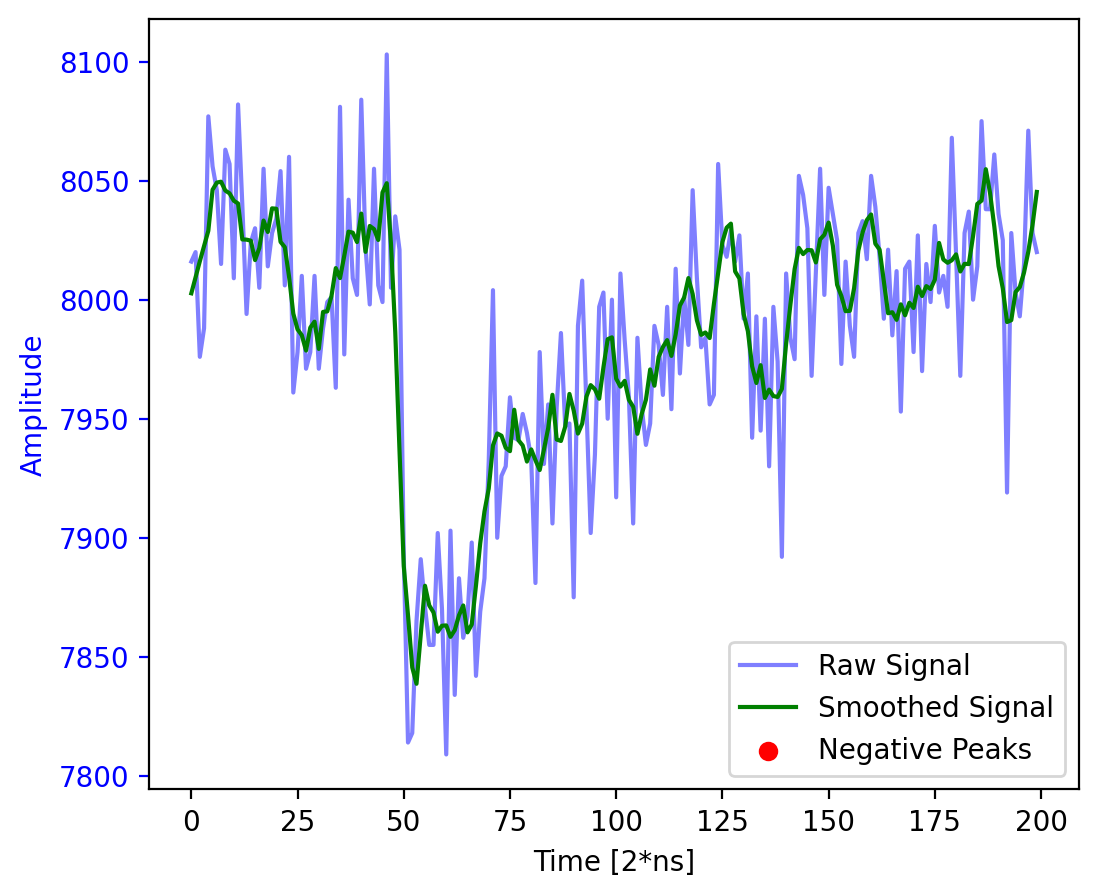

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter

# 创建一个figure和axis对象
fig, ax1 = plt.subplots(figsize=(6, 5))

# 假设 waveforms 是预先定义的数组或列表（在实际代码中应替换）
waveform = waveforms[0]
rand = np.random.randint(0, 2000)

wave = waveform[rand, 7:]

# 对原始波形应用Savitzky-Golay滤波
window_size = 10
poly_order = 2


smooth_wave = savgol_filter(wave, window_size, poly_order)


# 画出原始波形
ax1.plot(wave.flatten(), label="Raw Signal", color="blue", alpha=0.5)
ax1.plot(smooth_wave.flatten(), label="Smoothed Signal", color="green")

# 找到负峰值
peaks, _ = find_peaks(
    -smooth_wave,
    height=0,  # 最小高度
    prominence=0.4,  # 最小突出度
    threshold=0,  # 最小阈值
    distance=20,  # 最小峰间距
    width=5,  # 最小峰宽
    # rel_height=0.5  # 相对高度
)

# 标出负峰值
ax1.scatter(peaks, smooth_wave[peaks], color="red", label="Negative Peaks")

# 设置标签和标题
ax1.set_xlabel("Time [2*ns]")
ax1.set_ylabel("Amplitude", color="blue")
ax1.tick_params("y", colors="blue")

# 显示图例
ax1.legend()


# 显示图像
plt.show()

### **构建新的分析的类**


In [9]:
from typing import Union
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter


class Waver:
    peak_dtype = np.dtype([("position", int), ("height", float), ("integral", float)])

    def __init__(self, waveform: np.ndarray):
        self.waveform = waveform  # 原始波形
        self.filtered_waveform = None  # 滤波后的波形
        self.filtered_waveform_diff = None  # 滤波后的波形的一阶导数
        # 定义峰值信息的结构

        self.peaks_info = None  # 存储峰值信息（位置、峰高、积分）

    def waveform_filter(self, lowcut=0.1, highcut=0.5, fs=1.0, order=4, filter="SG"):
        """
        对波形进行带通滤波或Savitzky-Golay滤波
        :param lowcut: 低频截止
        :param highcut: 高频截止
        :param fs: 采样率
        :param order: 滤波器阶数
        :param filter: 滤波类型，"BW"为带通滤波器，"SG"为Savitzky-Golay滤波器
        """
        if filter == "BW":
            # 创建带通滤波器（Butterworth滤波器）
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist

            b, a = butter(order, [low, high], btype="band")
            # 应用带通滤波器
            self.filtered_waveform = filtfilt(b, a, self.waveform)

        elif filter == "SG":
            # 使用Savitzky-Golay滤波器
            window_size = 10
            poly_order = 2
            self.filtered_waveform = savgol_filter(self.waveform, window_size, poly_order)

        else:
            raise ValueError("filter must be 'BW' or 'SG'. You can add new ones by yourself.")

        self.filtered_waveform_diff = np.diff(self.filtered_waveform)

    def find_peaks(self, height=None, distance=None, threshold=None, prominence=None):
        """
        寻找波形中的峰值，并计算峰高和积分等信息
        :param height: 峰值的最小高度
        :param distance: 峰值之间的最小距离
        """
        # 使用 find_peaks 查找峰值索引和属性（如峰高）

        if self.filtered_waveform is None:
            self.filtered_waveform()

        # peaks, properties = find_peaks(
        #     waveform_used,
        #     height=height,
        #     distance=distance,
        #     threshold=threshold,
        #     prominence=prominence,
        # )
        filtered_waveform_diff = -np.diff(self.get_filtered_waveform())

        peaks, properties = find_peaks(
            -np.diff(filtered_waveform_diff), height=30, distance=2, prominence=0.7, width=4
        )

        # left_lens = peaks - properties["left_ips"]
        # right_lens = properties["right_ips"] - peaks

        starts = properties["left_ips"]
        ends = properties["right_ips"]
        peak_heights = self._peak_height_from_diff(starts, ends)

        peak_integrals = np.array([None for p in peaks])

        # 存储峰值信息（位置、峰高、积分）
        self.peaks_info = np.array(
            [(peaks[i], peak_heights[i], peak_integrals[i]) for i in range(len(peaks))],
            dtype=self.peak_dtype,
        )
        self.proeperties = properties
        # 更新 peaks 索引
        self.peaks = peaks

    def get_peaks(self):
        """
        获取当前的峰值信息（位置、峰高、积分等）
        :return: 包含峰值信息的数组
        """
        if self.peaks_info is None:
            self.find_peaks()
        return self.peaks_info

    def _peak_height_from_diff(self, starts, ends):
        """
        计算每个峰值的上升区间高度
        输入:
        - waveform: 1D数组，表示波形数据
        - peaks: 1D数组，表示多个峰值的位置索引
        - left_len: 左侧长度，用于计算上升区间的起始位置
        - right_len: 右侧长度，用于计算上升区间的结束位置

        输出:
        - peak_heights: 1D数组，每个峰值的上升区间高度
        """

        peak_heights = []

        for peak, start, end in zip(peaks, starts, ends):
            # 计算区间内的波形高度
            peak_height = np.sum(np.diff(-self.get_filtered_waveform())[start:end])
            peak_heights.append(peak_height)

        return np.array(peak_heights)

    def get_filtered_waveform(self):
        """
        获取滤波后的波形
        :return: 滤波后的波形
        """
        if self.filtered_waveform is None:
            self.waveform_filter()
        return self.filtered_waveform

In [10]:
# 这个是最新的代码
from typing import Union


import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter


class Waver:
    peak_dtype = np.dtype([
        ("position", int),
        ("height", float),
        ("integral", float),
        ("edge_start", int),
        ("edge_end", int),
    ])

    def __init__(self, waveform: np.ndarray):
        self.waveform = waveform  # 原始波形
        self.filtered_waveform = None  # 滤波后的波形
        self.filtered_waveform_diff = None  # 滤波后的波形的一阶导数
        # 定义峰值信息的结构

        self.peaks_info = None  # 存储峰值信息（位置、峰高、积分）

    def waveform_filter(self, lowcut=0.1, highcut=0.5, fs=1.0, order=4, filter="SG"):
        """
        对波形进行带通滤波或Savitzky-Golay滤波
        :param lowcut: 低频截止
        :param highcut: 高频截止
        :param fs: 采样率
        :param order: 滤波器阶数
        :param filter: 滤波类型，"BW"为带通滤波器，"SG"为Savitzky-Golay滤波器
        """
        if filter == "BW":
            # 创建带通滤波器（Butterworth滤波器）
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist

            b, a = butter(order, [low, high], btype="band")
            # 应用带通滤波器
            self.filtered_waveform = filtfilt(b, a, self.waveform)

        elif filter == "SG":
            # 使用Savitzky-Golay滤波器
            window_size = 10
            poly_order = 2
            self.filtered_waveform = savgol_filter(self.waveform, window_size, poly_order)

        else:
            raise ValueError("filter must be 'BW' or 'SG'. You can add new ones by yourself.")

        self.filtered_waveform_diff = np.diff(self.filtered_waveform)

    def find_peaks(self, height=None, distance=None, threshold=None, prominence=None):
        """
        寻找波形中的峰值，并计算峰高和积分等信息
        :param height: 峰值的最小高度
        :param distance: 峰值之间的最小距离
        """
        # 使用 find_peaks 查找峰值索引和属性（如峰高）

        if self.filtered_waveform is None:
            self.filtered_waveform()

        # peaks, properties = find_peaks(
        #     waveform_used,
        #     height=height,
        #     distance=distance,
        #     threshold=threshold,
        #     prominence=prominence,
        # )
        filtered_waveform_diff = -np.diff(self.get_filtered_waveform())

        peaks, properties = find_peaks(
            filtered_waveform_diff, height=30, distance=2, prominence=0.7, width=4
        )

        # left_lens = peaks - properties["left_ips"]
        # right_lens = properties["right_ips"] - peaks

        # starts = int(np.round(properties["left_ips"]))
        # ends = int(np.round(properties["right_ips"]))
        starts = [int(np.round(start)) for start in properties["left_ips"]]
        ends = [int(np.round(end)) for end in properties["right_ips"]]
        peak_heights = self._peak_height_from_diff(starts, ends)

        peak_integrals = np.array([None for p in peaks])

        # 存储峰值信息（位置、峰高、积分）
        self.peaks_info = np.array(
            [
                (
                    peaks[i],
                    peak_heights[i],
                    peak_integrals[i],
                    properties["left_ips"][i],
                    properties["right_ips"][i],
                )
                for i in range(len(peaks))
            ],
            dtype=self.peak_dtype,
        )
        self.proeperties = properties
        # 更新 peaks 索引
        self.peaks = peaks

    def get_peaks(self):
        """
        获取当前的峰值信息（位置、峰高、积分等）
        :return: 包含峰值信息的数组
        """
        if self.peaks_info is None:
            self.find_peaks()
        return self.peaks_info

    def _peak_height_from_diff(self, starts: Union[int, list[int]], ends: Union[int, list[int]]):
        peak_heights = []

        for start, end in zip(starts, ends):
            # 计算区间内的波形高度

            peak_height = np.sum(np.diff(-self.get_filtered_waveform())[start:end])
            peak_heights.append(peak_height)

        return np.array(peak_heights)

    def get_filtered_waveform(self):
        """
        获取滤波后的波形
        :return: 滤波后的波形
        """
        if self.filtered_waveform is None:
            self.waveform_filter()
        return self.filtered_waveform

#### 得到的波形和微分谱如下图所示

对于波形而言可以准确的找到多个峰的位置信息, 效果相对较好.

array([( 46, 466.59375, nan,  43,  49), (142, 376.21875, nan, 138, 144),
       (160, 358.225  , nan, 155, 162)],
      dtype=[('position', '<i8'), ('height', '<f8'), ('integral', '<f8'), ('edge_start', '<i8'), ('edge_end', '<i8')])

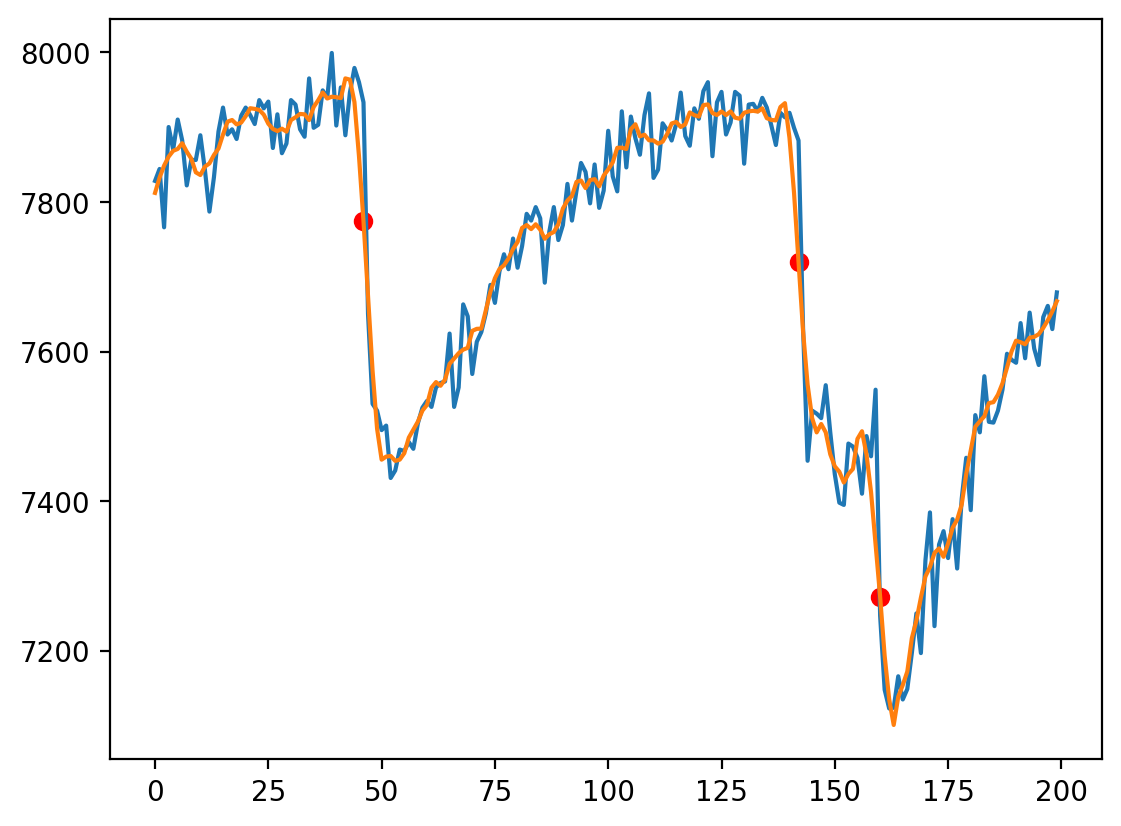

In [11]:
wave1 = Waver(waveforms[4][np.random.randint(10000), 7:])
wave1.get_filtered_waveform()

plt.plot(wave1.waveform)
plt.plot(wave1.get_filtered_waveform())
# 寻找峰值并计算峰高和积分
wave1.find_peaks(
    height=100,
    distance=20,
    prominence=0.7,
    threshold=2,
)

plt.scatter(
    wave1.get_peaks()["position"],
    [wave1.get_filtered_waveform()[pos] for pos in wave1.get_peaks()["position"]],
    color="red",
)

display(wave1.peaks_info)

array([( 46, 466.59375, nan,  43,  49), (142, 376.21875, nan, 138, 144),
       (160, 358.225  , nan, 155, 162)],
      dtype=[('position', '<i8'), ('height', '<f8'), ('integral', '<f8'), ('edge_start', '<i8'), ('edge_end', '<i8')])

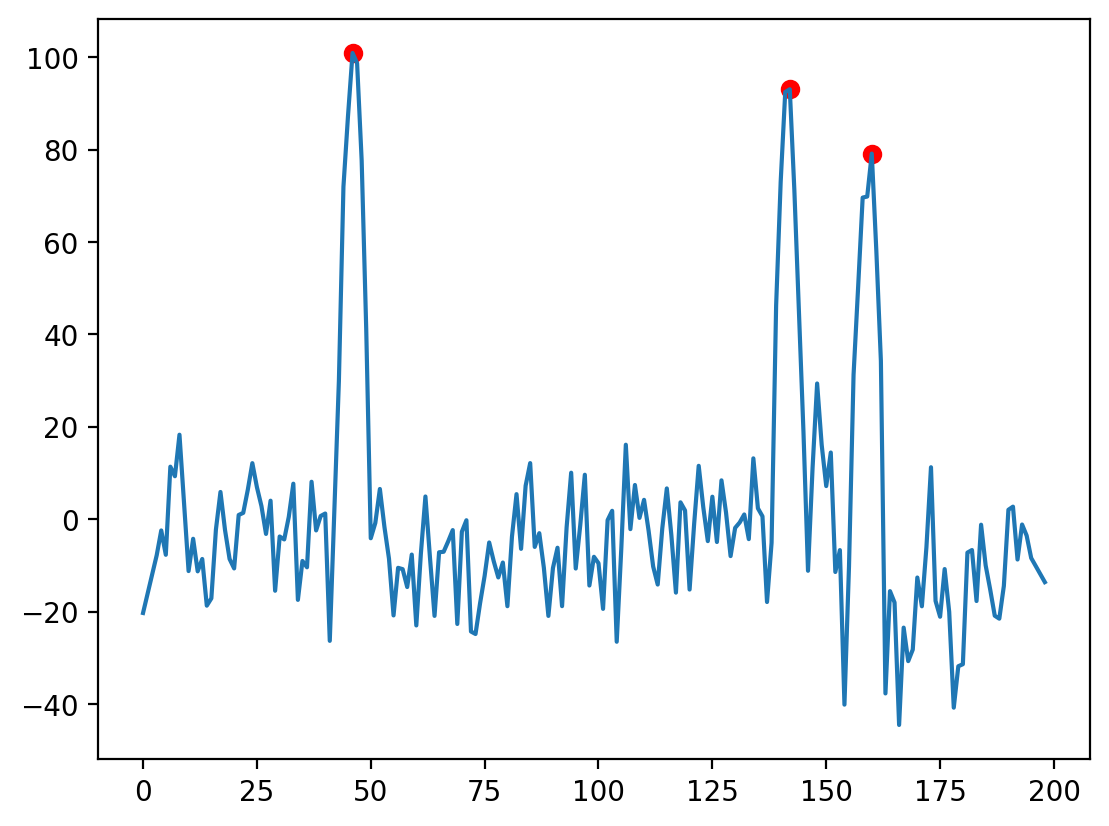

In [12]:
plt.plot(-np.diff(wave1.get_filtered_waveform()))


a = find_peaks(
    -np.diff(wave1.get_filtered_waveform()), height=30, distance=2, prominence=0.7, width=4
)

wave1.find_peaks()
display(wave1.peaks_info)
plt.scatter(a[0], a[1]["peak_heights"], color="red")

### 重要的图: 滤波效果, 微分谱, 寻峰效果和高度计算效果展示

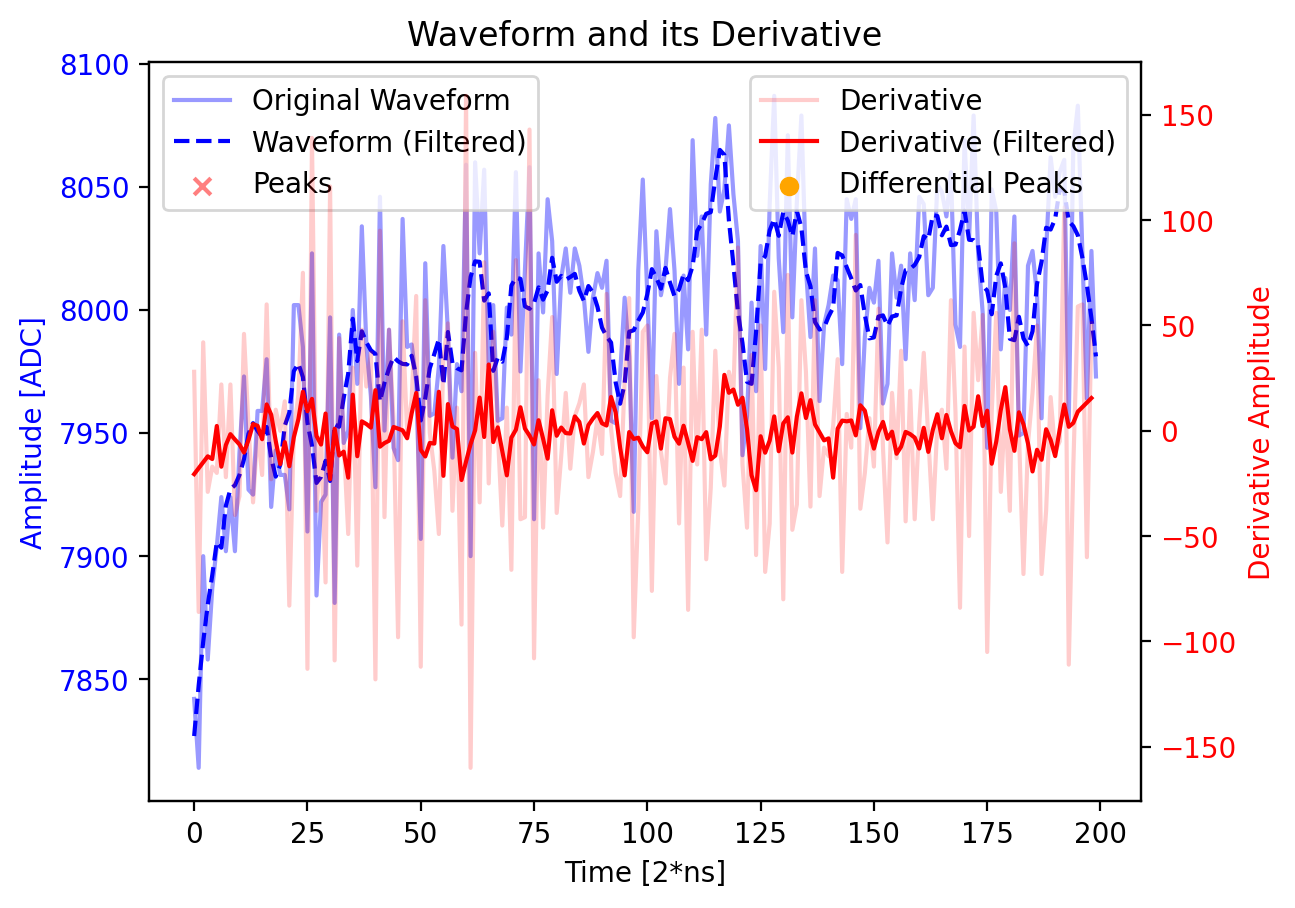

In [13]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import find_peaks

# 假设 waveforms 是您现有的数据
# 示例代码, wave1 和 find_peaks 会基于您原有的数据结构进行适配


def peak_height_from_diff(waveform, peak, left_len, right_len):
    # 计算峰值的上升区间

    rising_range_start = int(np.ceil(peak - left_len))
    rising_range_end = int(np.ceil(peak + right_len))

    # 计算区间内的波形高度
    peak_height = np.sum(np.diff(-waveform)[rising_range_start:rising_range_end])

    return peak_height


wave1 = Waver(waveforms[0][np.random.randint(10000), 7:])
wave1.get_filtered_waveform()

# 创建一个新的绘图
fig, ax1 = plt.subplots()

# 绘制原始波形和滤波后的波形
ax1.plot(wave1.waveform, label="Original Waveform", color="blue", alpha=0.4)
ax1.plot(wave1.get_filtered_waveform(), label="Waveform (Filtered)", color="blue", linestyle="--")

# 寻找峰值并计算峰高和积分
wave1.find_peaks(height=100, distance=20, prominence=0.5, threshold=2)

# 在第一个 Y 轴上标出峰值位置
ax1.scatter(
    wave1.get_peaks()["position"],
    [wave1.get_filtered_waveform()[pos] for pos in wave1.get_peaks()["position"]],
    color="red",
    label="Peaks",
    alpha=0.5,
    marker="x",
)

ax1.set_xlabel("Time [2*ns]")
ax1.set_ylabel("Amplitude [ADC]", color="blue")  # 设置Y轴颜色与滤波后的波形一致
ax1.tick_params(axis="y", labelcolor="blue")  # Y轴标签颜色与滤波后波形颜色一致
ax1.legend(loc="upper left")

# 创建一个新的 Y 轴，用于绘制第二个数据集
ax2 = ax1.twinx()

# 绘制 -diff(waveform) 的图像
ax2.plot(-np.diff(wave1.waveform), label="Derivative", color="red", alpha=0.2)
ax2.plot(-np.diff(wave1.get_filtered_waveform()), label="Derivative (Filtered)", color="red")
# ax2.plot(-np.diff(wave1.get_filtered_waveform()), label='Derivative (differential)', color='purple')

# 使用 find_peaks 查找差分波形的峰值
a = find_peaks(
    -np.diff(wave1.get_filtered_waveform()), height=30, distance=2, prominence=0.7, width=4
)
ax2.scatter(a[0], a[1]["peak_heights"], color="orange", label="Differential Peaks")

# 设置第二个 Y 轴的标签
ax2.set_ylabel("Derivative Amplitude", color="red")  # 设置Y轴颜色与差分波形一致
ax2.tick_params(axis="y", labelcolor="red")  # Y轴标签颜色与差分波形颜色一致

# 添加图例
ax2.legend(loc="upper right")


wave1_diff = -np.diff(wave1.get_filtered_waveform())
peak1, properties = find_peaks(
    -np.diff(wave1.get_filtered_waveform()), height=30, distance=2, prominence=0.7, width=4
)

for i, peak in enumerate(peak1):
    # ax2.axvspan(
    #     peak - 0.5 * properties["widths"][i],
    #     peak + 0.55 * properties["widths"][i],
    #     alpha=0.2,
    #     color="green",
    # )

    ax2.axvspan(
        properties["left_ips"][i],
        properties["right_ips"][i],
        alpha=0.2,
        color="green",
    )

left_lens = peak1 - properties["left_ips"]
right_lens = properties["right_ips"] - peak1


# 获取filtered_waveform
filtered_waveform = wave1.get_filtered_waveform()

# 绘制filtered_waveform


# 对每个峰值进行处理
for peak, left_len, right_len in zip(peak1, left_lens, right_lens):
    # 计算垂直线的起始位置
    start = int(np.round(peak - left_len))
    # 计算峰值高度
    peak_height = peak_height_from_diff(filtered_waveform, peak, left_len, right_len)

    # 绘制垂直线
    ax1.vlines(
        start,
        filtered_waveform[start] - peak_height,
        filtered_waveform[start],
        color="purple",
        linewidth=3,
    )


plt.title("Waveform and its Derivative")
# 显示图表
plt.show()

### 高度算法测试
实际上这个应该放在前面, 为了偷懒,

在计算高度的方面考虑两种方案, 
1. 通过 find_peaks 给出的微分谱的拐点信息进行积分
2. 通过 peak 位置和 width 在微分谱上进行积分
看起来第一种的效果更好一些.

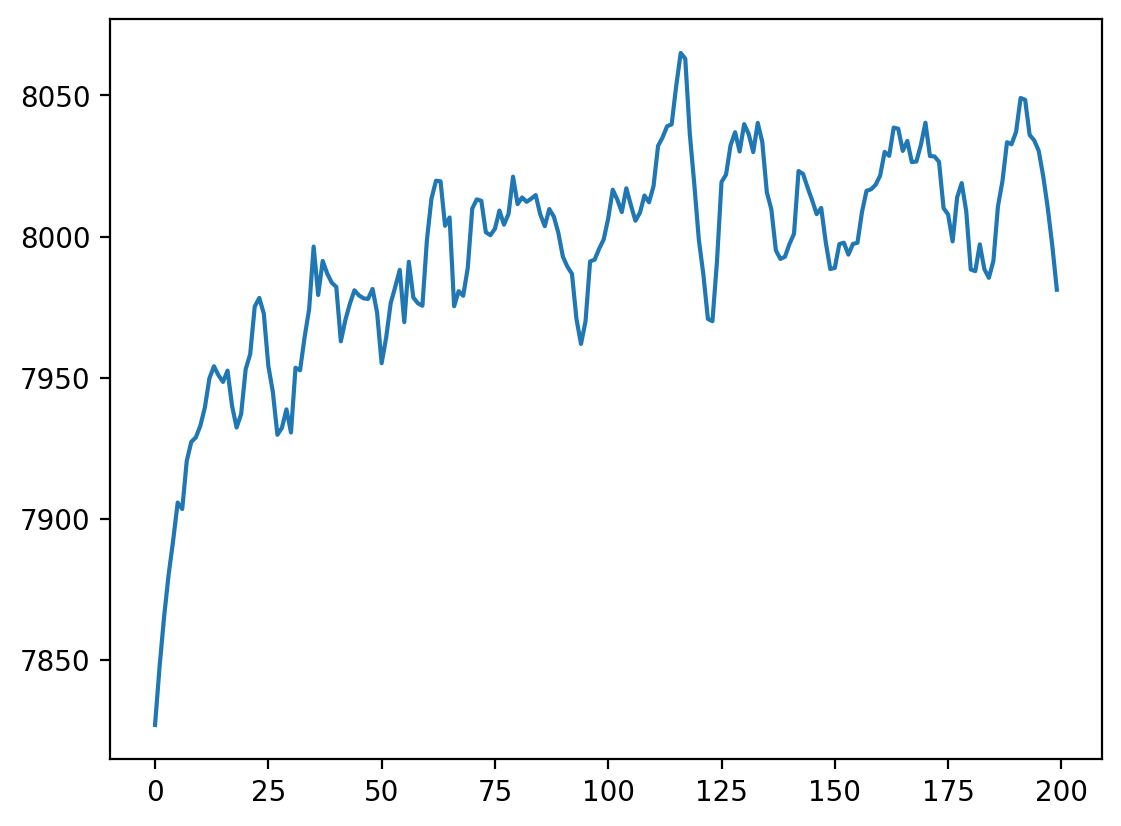

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 假设wave1.get_filtered_waveform()已定义
# 假设peak1是峰值列表
# 假设properties["widths"]已定义

# left_lens = 0.65 * properties["widths"]
# right_lens = 0.75 * properties["widths"]




left_lens = peak1 - properties["left_ips"]
right_lens = 1.1 * (properties["right_ips"] - peak1)


# 获取filtered_waveform
filtered_waveform = wave1.get_filtered_waveform()

# 绘制filtered_waveform
plt.plot(filtered_waveform)

# 对每个峰值进行处理
for peak, left_len, right_len in zip(peak1, left_lens, right_lens):
    # 计算垂直线的起始位置
    start = int(np.round(peak - left_len))
    # 计算峰值高度
    peak_height = peak_height_from_diff(filtered_waveform, peak, left_len, right_len)
    # 绘制垂直线
    plt.vlines(
        start,
        filtered_waveform[start] - peak_height,
        filtered_waveform[start],
        color="red",
    )

# 显示图形
plt.show()

## 系统化分析

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 对于 55V 的电压, 尝试找到对应的峰值进行拟合.

In [ ]:
pip 

In [ ]:
import Waver
from tqdm import tqdm


waveform = waveforms[2][:, 7:]

waves = [Waver.Waver(waveform[i, 7:]) for i in range(len(waveform))]

for wave in tqdm(waves, desc="Processing waves"):
    wave.waveform_filter(filter="SG")
    wave.find_peaks()



Processing waves: 100%|██████████| 406493/406493 [01:47<00:00, 3772.97it/s]


通过寻峰得到的高度谱, 看起来效果非常的好, 下一步几个方向可以考虑
1. 通过得到的峰的时间信息, 统计峰之间的时间的间隔, 得到分布的信息.
2. 将这个算法尝试应用到 muon-veto 上对 muon-veto 进行分析.


In [84]:
# 这是之前的代码用来比较的
peaks = [
    np.min(waveform[: len(waveform), 7 + 25 : 7 + 100], axis=1)
    - np.floor(np.mean(waveform[: len(waveform), 7:20], axis=1))
    for waveform in waveforms
]

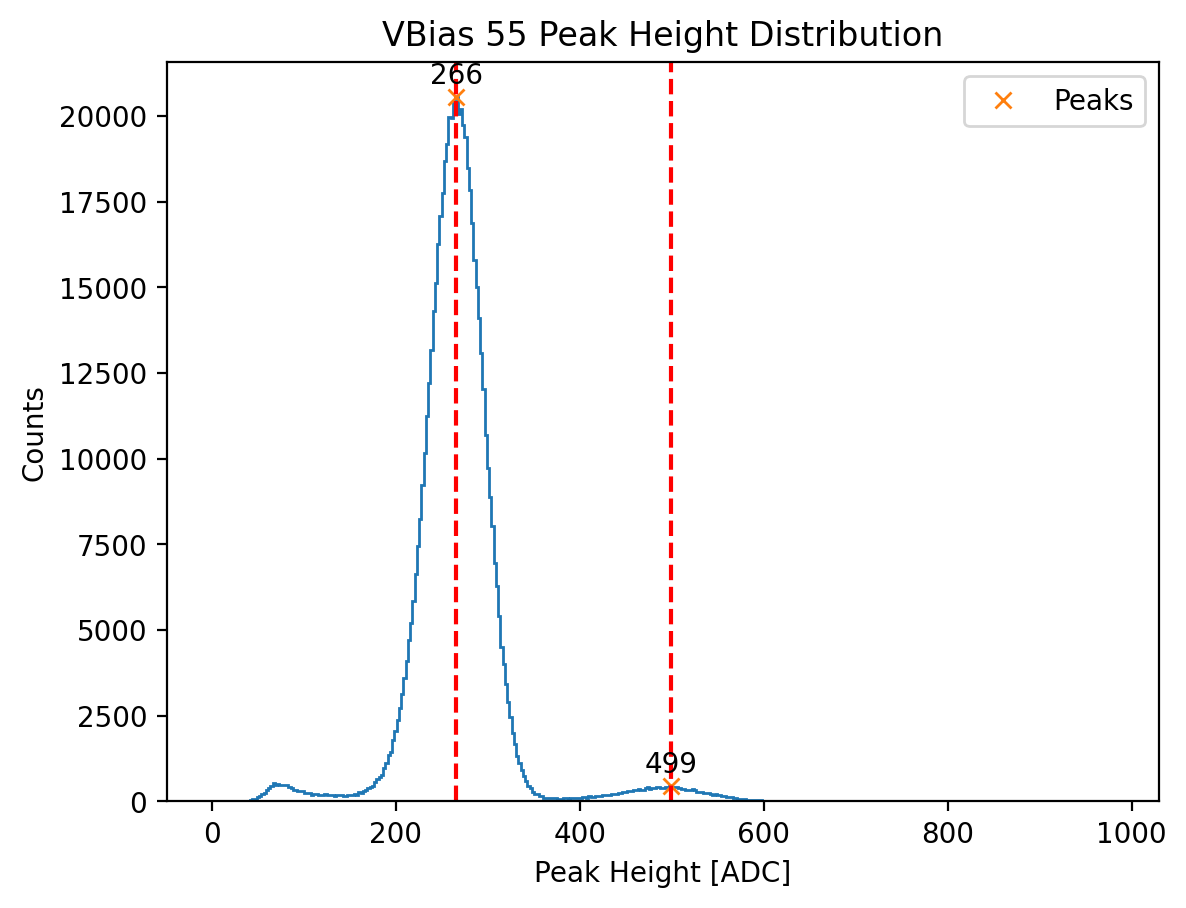

In [85]:
peaks_heights = np.concatenate([wave.get_peaks()["height"] for wave in waves])

counts, bin_edges, _ = plt.hist(peaks_heights, bins=400, histtype="step")

bin_size = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1] + bin_size / 2

peak_indices, props = find_peaks(
    counts, height=50, distance=20, width=20
)  # 使用 find_peaks 在 counts 里找峰

plt.plot(bin_centers[peak_indices], counts[peak_indices], "x", label="Peaks")  # 在峰值位置做标记

for peak_indice in peak_indices:
    plt.axvline(bin_centers[peak_indice], color="red", linestyle="--")
    
    plt.annotate(
        f"{bin_centers[peak_indice]:.0f}",
        (bin_centers[peak_indice], counts[peak_indice]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )
plt.xlabel("Peak Height [ADC]")
plt.ylabel("Counts")
plt.title("VBias 55 Peak Height Distribution")


plt.legend()

In [ ]:
import numpy as np

wave1.peaks_info

array([],
      dtype=[('position', '<i8'), ('height', '<f8'), ('integral', '<f8')])

In [1]:
pip install nbdime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 4.0 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
nbdime config-git --enable

SyntaxError: invalid syntax (1842779921.py, line 1)